# Cost Reduction

We now see that solar can save a lot on grid consumption, but what we really care about is how much money it'll save.  In this notebook, we'll explore the differences of cost with and without solar.  We'll continue with the processed data from the previous notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
usage_data = pd.read_csv('../data/processed/Solar ROI - usage_data_with_generation.csv', parse_dates=['date'])
usage_data['date'] = pd.to_datetime(usage_data['date'], utc=True)
usage_data['start_time'] = pd.to_datetime(usage_data['start_time'], format='%H:%M:%S').dt.time

## Cost Calculation

### Time of Use (Current Plan)

We're currently on a the E-TOU-C plan, which is the [Residential Time-of-Use Peak Pricing 4-9 p.m. Every Day](https://www.pge.com/en/account/rate-plans/find-your-best-rate-plan/time-of-use-rate-plans.html#ResTOUplans-item-b206ca04d2) plan.  The structure for energy billing is as follows:

For the months October through May:
- The baseline is 11 kWh per day; i.e. the first 11 kWh per day are billed at 0.31976 and then 0.40827 thereafter.
- However, during the hours from 16:00 to 21:00 each day, the rates are 0.34811 and 0.43662 respectively.

For the months of June through September:
- The baseline is 9.8 kWh per day; i.e. the first 9.8 kWh per day are billed at 0.34811 and then 0.45589 thereafter.
- However, during the hours from 16:00 to 21:00 each day, the rates are 0.45082 and 0.53933 respectively.

We'll need to model the rate schedule to calculate our expected costs.

In [2]:
def calculate_tou_cost(row, usage_column='usage'):
    date, month = row['date'], row['date'].month
    start_time, usage = row['start_time'], row[usage_column]

    # Define peak pricing hours
    peak_start_time = pd.to_datetime("16:00").time()
    peak_end_time = pd.to_datetime("21:00").time()

    # Adjust threshold based on time of year
    if month in [1, 2, 3, 4, 5, 10, 11, 12]:  # Jan-May, Oct-Dec
        threshold = 11

        # Adjust rate details for Tier 1 and Tier 2 during peak hours
        if peak_start_time <= start_time <= peak_end_time:
            rate_tier1 = 0.34811
            rate_tier2 = 0.43662
        else:  # Off-peak hours
            rate_tier1 = 0.31976
            rate_tier2 = 0.40827
    else:  # Jun-Sep
        threshold = 9.8

        # Adjust rate details for Tier 1 and Tier 2 during peak hours
        if peak_start_time <= start_time <= peak_end_time:
            rate_tier1 = 0.45082
            rate_tier2 = 0.53933
        else:  # Off-peak hours
            rate_tier1 = 0.36738
            rate_tier2 = 0.45589

    # Calculate cost based on tiers and threshold
    if usage <= threshold:
        cost = usage * rate_tier1
    else:
        cost = threshold * rate_tier1 + (usage - threshold) * rate_tier2

    return cost

# Create a new column 'cost_tou' to store the cost for each time window
tqdm.pandas(desc="Calculating TOU costs")
usage_data['cost_tou'] = usage_data.progress_apply(calculate_tou_cost, axis=1)

Calculating TOU costs:   0%|          | 0/35136 [00:00<?, ?it/s]

## Solar Rate (E-1)

We'll likely wind up on the [E-1](https://www.pge.com/en/account/rate-plans/find-your-best-rate-plan/tiered-rate-plan.html#accordion-c97590f9fe-item-b47fc5f5ee) plan once we go forward with solar.  The rates are a little steeper for the plan, but remember they will be largely offset based on our previous analysis.  The structure for energy billing is as follows:

For the months of November through April:
- The baseline for Tier 1 is 11 kWh per day and 44 kWh for Tier 2.  The rates are 0.35841/kWh and 0.44692/kWh respectively.  Tier 3 keeps the same pricing as Tier 2 in the current version.

For the monthos of May through October:
- The baseline for Tier 1 is 9.8 kWh per day and 39.2 kWh for Tier 2.  The pricing doesn't change from season to season.

We'll model this rate plan similar to our approach above.

In [3]:
def calculate_e1_cost(row, usage_column='usage_adjusted'):
    date, month = row['date'], row['date'].month
    usage = row[usage_column]

    # Define thresholds and rates for e1 plan
    if 5 <= month <= 10:  # May-Oct
        tier1_threshold = 9.8
        tier2_threshold = 39.2
        rate_tier1 = 0.35841
        rate_tier2 = 0.44692
        rate_tier3 = 0.44692
    else:  # Nov-Apr
        tier1_threshold = 11
        tier2_threshold = 44
        rate_tier1 = 0.35841
        rate_tier2 = 0.44692
        rate_tier3 = 0.44692

    # Calculate cost based on tiers and thresholds
    if usage <= tier1_threshold:
        cost = usage * rate_tier1
    elif usage <= tier2_threshold:
        cost = tier1_threshold * rate_tier1 + (usage - tier1_threshold) * rate_tier2
    else:
        cost = tier1_threshold * rate_tier1 + (tier2_threshold - tier1_threshold) * rate_tier2 + (usage - tier2_threshold) * rate_tier3

    return cost

# Create a new column 'cost_e1' to store the cost for each time window
tqdm.pandas(desc="Calculating solar offset e1 costs")
usage_data['cost_e1_solar'] = usage_data.progress_apply(calculate_e1_cost, axis=1)


Calculating solar offset e1 costs:   0%|          | 0/35136 [00:00<?, ?it/s]

Comparing E-TOU-C to solar offset E-1 introduces a compounding variable.  We don't have a way to attribute savings to either the rate plan change or solar offset.  To control for the rate plan change, we can generate costs for E-1 without solar offset.  This would isolate the variables in between the 3 states -- we'll see the savings (or added cost) of moving to the E-1 plan without solar and then the total savings within E-1 rate solar offset gains us.

In [4]:
tqdm.pandas(desc="Calculating e1 costs")
usage_data['cost_e1'] = usage_data.progress_apply(calculate_e1_cost, axis=1, usage_column='usage')

Calculating e1 costs:   0%|          | 0/35136 [00:00<?, ?it/s]

## Analysis

We now have energy cost data to compare.  We cannot call this a bill yet.  A bill would container fixed charges and generation charges.  We'll get to that in the next notebook.  For now, let's just compare the energy costs side by side.

Let's start with comparing energy costs each month.  Our actual bill doesn't land on month boundaries, so we won't compare this to real bills.  We'll simply compare our two rate simulation outputs side by side to control for variables.

/var/folders/vn/b2b_gx7s0_g6gkr8x5wnw9600000gn/T/ipykernel_8351/1072923128.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_costs = filtered_data.groupby(filtered_data['date'].dt.to_period("M")).agg({


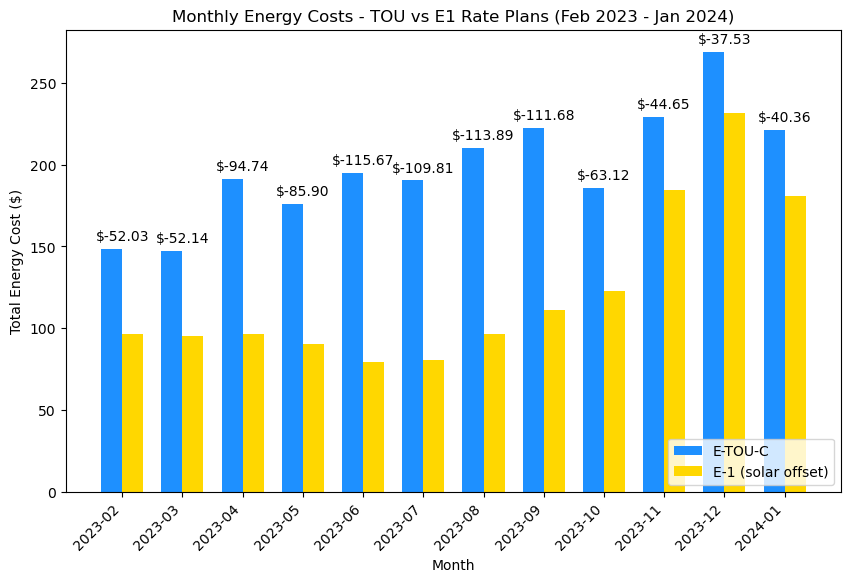

In [5]:
usage_data['date'] = usage_data['date'].dt.tz_convert('America/Los_Angeles')

start_date = pd.Timestamp('2023-02-01', tz='America/Los_Angeles')
end_date = pd.Timestamp('2024-01-31', tz='America/Los_Angeles')
filtered_data = usage_data[(usage_data['date'] >= start_date) & (usage_data['date'] <= end_date)]
monthly_costs = filtered_data.groupby(filtered_data['date'].dt.to_period("M")).agg({
    'cost_tou': 'sum',
    'cost_e1': 'sum',
    'cost_e1_solar': 'sum'
})

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
bar_positions_tou = range(len(monthly_costs))
bar_positions_e1 = [pos + bar_width for pos in bar_positions_tou]

ax.bar(bar_positions_tou, monthly_costs['cost_tou'], width=bar_width, color='dodgerblue', label='E-TOU-C')
ax.bar(bar_positions_e1, monthly_costs['cost_e1_solar'], width=bar_width, color='gold', label='E-1')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions_tou])
ax.set_xticklabels(monthly_costs.index.astype(str), rotation=45, ha='right')  # Tilt the labels
ax.legend(loc='lower right', labels=['E-TOU-C', 'E-1 (solar offset)'])

# Add annotations for solar cost savings at the top of each bar
for pos_tou, pos_e1, savings in zip(bar_positions_tou, bar_positions_e1, monthly_costs['cost_tou'] - monthly_costs['cost_e1_solar']):
    ax.text(pos_tou + bar_width / 2, monthly_costs['cost_tou'][pos_tou] + 5, f'${-savings:.2f}', ha='center')

ax.set_xlabel('Month')
ax.set_ylabel('Total Energy Cost ($)')
ax.set_title('Monthly Energy Costs - TOU vs E1 Rate Plans (Feb 2023 - Jan 2024)')

# Show the plot
plt.show()

We can now see the marked savings with solar.  However, we still have that confounding variable.  Let's get that in check by visualizing what the E1 plan would cost us currently.

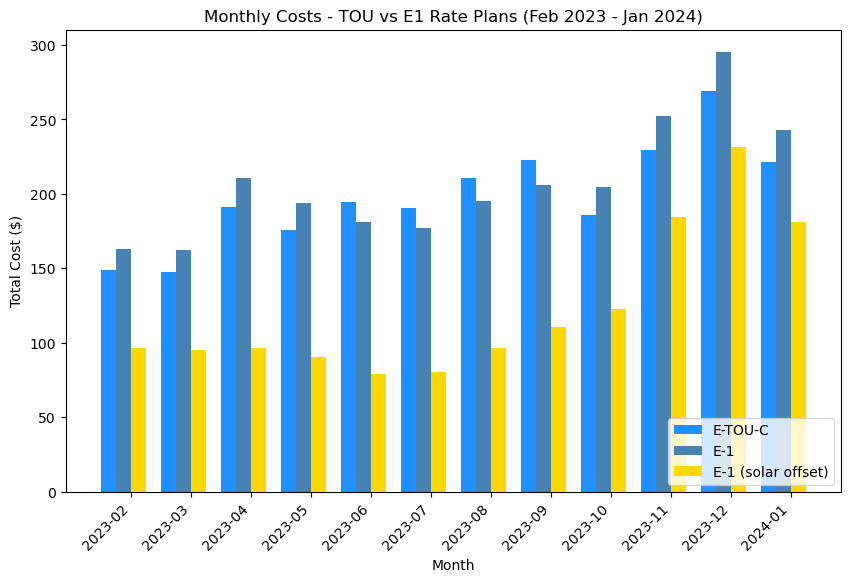

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
bar_positions_tou = range(len(monthly_costs))
bar_positions_e1 = [pos + bar_width for pos in bar_positions_tou]
bar_positions_e1_solar = [pos + 2 * bar_width for pos in bar_positions_tou]

ax.bar(bar_positions_tou, monthly_costs['cost_tou'], width=bar_width, color='dodgerblue', label='E-TOU-C')
ax.bar(bar_positions_e1, monthly_costs['cost_e1'], width=bar_width, color='steelblue', label='E-1')
ax.bar(bar_positions_e1_solar, monthly_costs['cost_e1_solar'], width=bar_width, color='gold', label='E-1 Solar')
ax.set_xticks([pos + 1.5 * bar_width for pos in bar_positions_tou])
ax.set_xticklabels(monthly_costs.index.astype(str), rotation=45, ha='right')  # Tilt the labels
ax.legend(loc='lower right', labels=['E-TOU-C', 'E-1', 'E-1 (solar offset)'])
ax.set_xlabel('Month')
ax.set_ylabel('Total Cost ($)')
ax.set_title('Monthly Costs - TOU vs E1 Rate Plans (Feb 2023 - Jan 2024)')

# Show the plot
plt.show()

Let's save our progress with the calculations...

In [7]:
usage_data.to_csv('../data/processed/Solar ROI - usage_data_with_generation_and_energy_cost.csv')